# Import relevant packages

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f
from astropy.table import Table

# Simulate data
Simulate data with a smooth broken power law, with injected noise, following the model below:

$S_\nu(t) = S_{\rm \nu,peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Let us assume that all of our data is in a narrow enough frequency band that we do not have to consider the power law spectrum:

$ S_\nu(\nu) \propto \nu^\alpha$


In [178]:
# define smooth broken power law function
def smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s):
    s = 10**log_s
    y = S_peak*((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1/s)
    return y

# define our input parameters
t = np.logspace(0, 3, 100)
S_peak = 100
t_peak = 150
delta_1 = 1.1
delta_2 = -0.8
log_s = 0.5

# generate smooth broken power law
true_relation = smooth_broken_power_law(t, S_peak, t_peak, delta_1, delta_2, log_s)

# inject gaussian noise 
ltnoise = np.random.normal(scale= 2, size=len(t))
gtnoise = np.random.normal(scale= 15, size=len(t))

# I will not add any errors for now as I am not sure how to deal with scaling the errors with the log scale
# err = np.random.normal(loc= 1, scale= 0.1, size=len(t))

table = np.column_stack((t, true_relation, 100*abs(ltnoise)))
data = Table(table, names=['time', 'flux', 'rms'])
for i in range(0,len(data['time'])):
    if data['flux'][i] < 10:
        data['flux'][i] = data['flux'][i] + ltnoise[i]
    else:
        data['flux'][i] = data['flux'][i] + gtnoise[i]

data

time,flux,rms
float64,float64,float64
1.0,-1.516326466709894,192.02504263221869
1.0722672220103233,-1.1922828604065598,162.84299194649688
1.1497569953977358,1.1336339777810598,66.26932162875232
1.2328467394420661,3.378421790209641,286.9911653021239
1.321941148466029,0.319852613302517,22.92240026253494
1.4174741629268053,2.4816484556246987,188.87691635308812
1.5199110829529336,3.3924613204586267,275.2284986597359
1.6297508346206442,0.5154612316690164,17.578527314427276
1.7475284000076838,0.7430028959154784,0.3387911027558041


# Make a plot of the lightcurve
follow the same modular procedure as in the <span style="text-decoration: underline;">Radio Light Curve Module</span> notebook

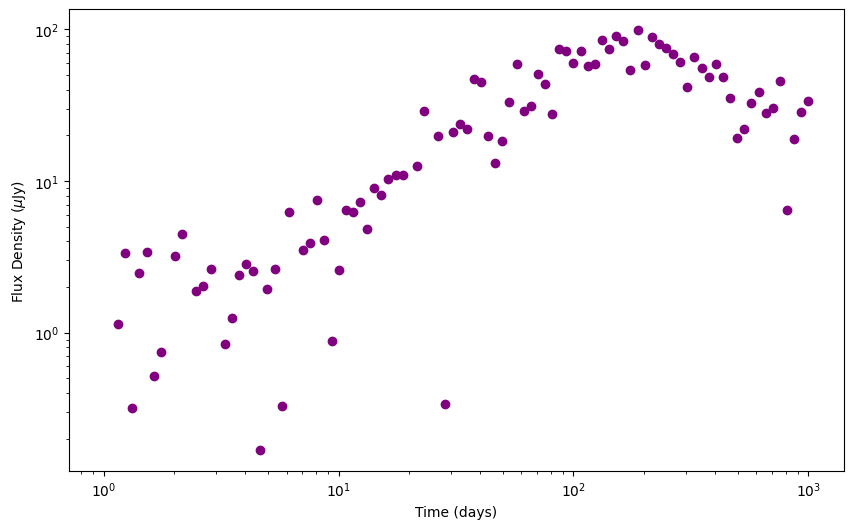

In [182]:
def plot_data(ax, data, scaled=False, **kwargs):
    for row in data:
        time = row['time']
        
        if scaled:
            flux = row['scaled_flux']
            # rms = row['scaled_rms']
        else:
            flux = row['flux']
            # rms = row['rms']

        ax.scatter(time, flux, color='purple', marker='o')
    return

def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    plot_data(ax, data, scaled=scaled)

    # set axis scales to log
    ax.set_yscale('log')
    ax.set_xscale('log')

    #Label axes, set axis limits etc.
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
        ax.set_title('Scaled to 3 GHz')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')

    if model!=None:
        plot_model(model, params, data['time'], ax)

make_plot(data)

# Determing and scaling data based on spectral index
If we had information across frequencies, we would perform this step. I will skip this step for now and just assume the 'data' is scaled to one frequency.

# Fitting the data with MCMC and determining evidence for a turnover
We will now try to fit our simulated data to two models, one with a turnover, and another without. We will perform an MCMC  fit using the [`emcee`](http://dfm.io/emcee/current/) package to determine the lightcurve parameters of our data. 

One point of confusion for me is how to decide a good prior, probability, and likelihood. Of course, we know that $\delta_1>0$, and $\delta_2<0$, and I suppose we'll want to impose, for the turnover model, that $0<t_{peak}<1000$, as our simulated data only goes this far.

For now I will use the functions in the <span style="text-decoration: underline;">Radio Light Curve Module</span> notebook blindly until we can discuss this further

In [93]:
def lnprior(theta):
    F_peak, t_peak, delta_1, delta_2, log_s = theta

    if 0.0 < t_peak < 1000.0 and delta_1 > 0.0 and delta_2 < 0.0 and log_s < 3:
        return 0.0
    
    else:
        return -np.inf

In [98]:
def lnlikelihood(theta, t, S):
    F_peak, t_peak, delta_1, delta_2, log_s = theta

    model = smooth_broken_power_law(t, F_peak, t_peak, delta_1, delta_2, log_s)

    return -0.5*(np.sum((S-model)**2))

In [99]:
def lnposterior(theta, t, S):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlikelihood(theta, t, S)

Now we will prepare to actually perform MCMC. The first step is to write a function that gets the starting positions of the walkers for each of the parameters. Then we will write our function run_mcmc

In [154]:
def get_starting_pos(nwalkers, ndim=5):
    '''
    Get the starting positions of the walkers for each parameter. Determine reasonable starting values for each parameter based on the data
    '''
    S_peak = 100
    t_peak = 150
    delta_1 = 1.1
    delta_2 = -0.8
    log_s = 0.5
    
    # we add some small, gaussian distributed offset to the starting position for each walker so that they are able to traverse 
    # more of the parameter space
    pos = [np.asarray([S_peak, t_peak, delta_1, delta_2, log_s]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

In [155]:
def run_mcmc(data, niters=1000, nthreads=1, nwalkers=200, ndim=5):
    '''
    Run the emcee Ensemble Sampler for MCMC.

    Parameters:
    - data: The file path for the lightcurve data.
    - niters: The number of steps to run the sampler.
    - nthreads: The number of threads to run the sampler
    - nwalkers: The number of walkers (chains) in the ensemble.
    - ndim: The number of parameters in the lightcurve model.

    Returns:
    - sampler: The samples from the MCMC chain.
    - chain: The array of chains for each parameter extracted from the sampler
    '''
    # get data
    t = data['time']
    flux = data['flux']

    # initialize starting positions
    initial_positions = get_starting_pos(nwalkers)

    # set up Ensemble Sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, args=(t, flux), threads=nthreads)

    # Run the sampler, tracking the computation time:
    start = timer()
    sampler.run_mcmc(initial_positions, niters)
    end = timer()

    # get the chain
    chain = sampler.chain

    # print computation time
    print("Computation time: %f s"%(end-start))

    return sampler, chain

In [156]:
sampler, chain = run_mcmc(data, niters=3000, nwalkers=600)

Computation time: 417.096644 s


Inspect our chains to see if the algorithm is coverging to a sloution for each parameter. Below is a function that will plot each walker's movement around the parameter space

In [157]:
chain.shape
# (nwalkers, niters, ndim)

(600, 3000, 5)

In [158]:
def plot_parameter_space(chain):
    '''
    Plot the movement of walkers in the parameter space for each parameter.

    Parameters:
    - chain: The MCMC chain (shape: (nwalkers, niters, ndim))

    Returns:
    - None (displays the plot)
    '''

    nwalkers, niters, ndim = chain.shape
    params = ['$S_{peak}$', '$t_{peak}$', '$\\delta_1$', '$\\delta_2$', '$\\log_{10}(s)$']

    # create a figure with subplots
    fig, axs = plt.subplots(ndim, figsize=(7, 20), sharex=True)

    # Iterate over parameters
    for i, (ax,param_name) in enumerate(zip(axs,params)):
        # Iterate over walkers
        for j in range(nwalkers):
            # Plot the movement of the walker for the parameter
            ax.plot(np.arange(niters), chain[j, :, i], '-', markersize=2, color='k', alpha=0.4)
        # Set labels and title for the subplot
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters/2)


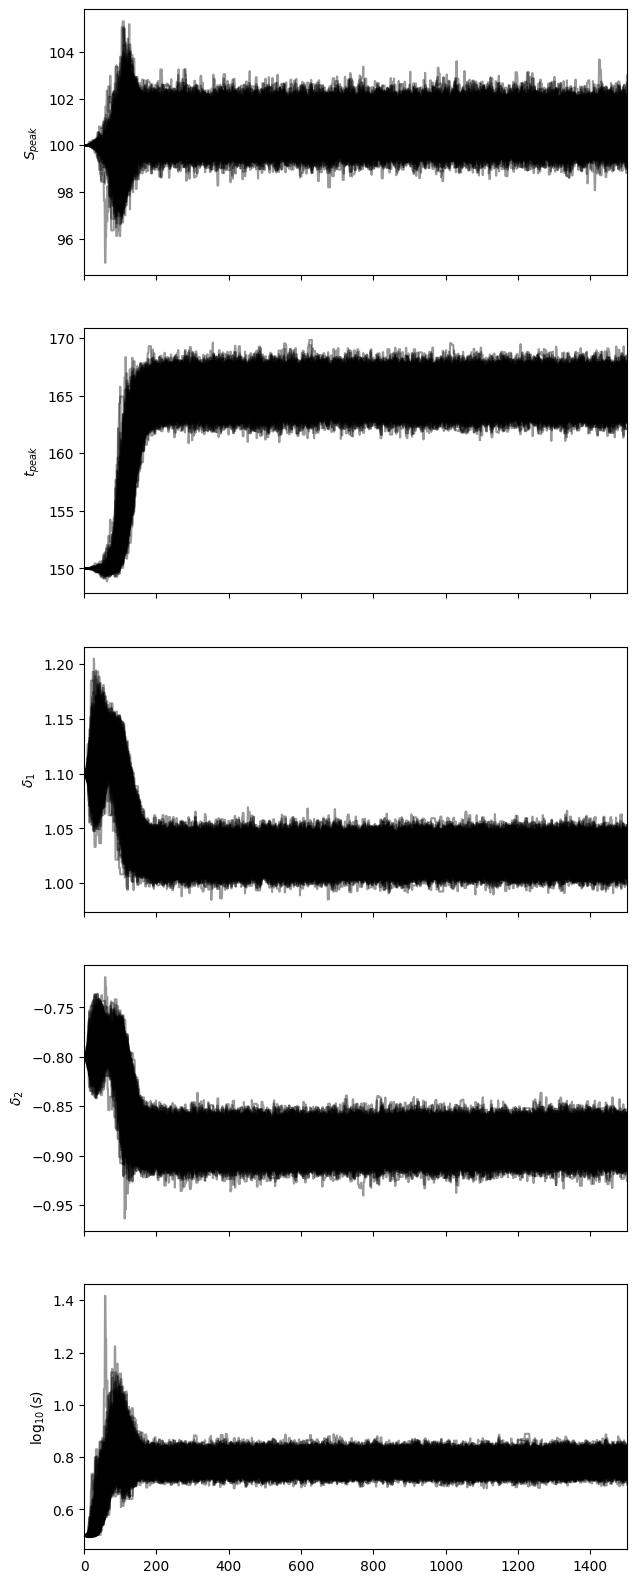

In [159]:
plot_parameter_space(chain)

Based on the chain plots, determine ~ how long the burn in takes and create a new, 'good' chain that cuts out the burn in period. By eye, all the parameters seem to have converged around a value after around 200 iterations, so I will call this the burn in period.

In [160]:
burn_in = 200
good_chain = chain[:,burn_in:,:] # we want niters to go from after the burn_in onwards. This is the second axis in the chain 3D array
good_chain.shape

(600, 2800, 5)

Now we'll want to make a corner plot of all the parameters, just from the good part of the chain

In [161]:
def corner_plot(chain, savefile='corner_plot.png'):
    '''
    '''
    # load in relevant variables
    ndim = chain.shape[2]
    params = ['$S_{peak}$', '$t_{peak}$', '$\\delta_1$', '$\\delta_2$', '$\\log_{10}(s)$']

    # make sure the chain will be the correct shape
    reshaped_chain = chain.reshape(-1, ndim)

    # create the corner plot
    fig = corner.corner(reshaped_chain, labels= params, quantiles=[0.16, 0.5, 0.84], show_titles=True)

    # save the file
    plt.savefig(savefile)

    # display the plot
    plt.show()

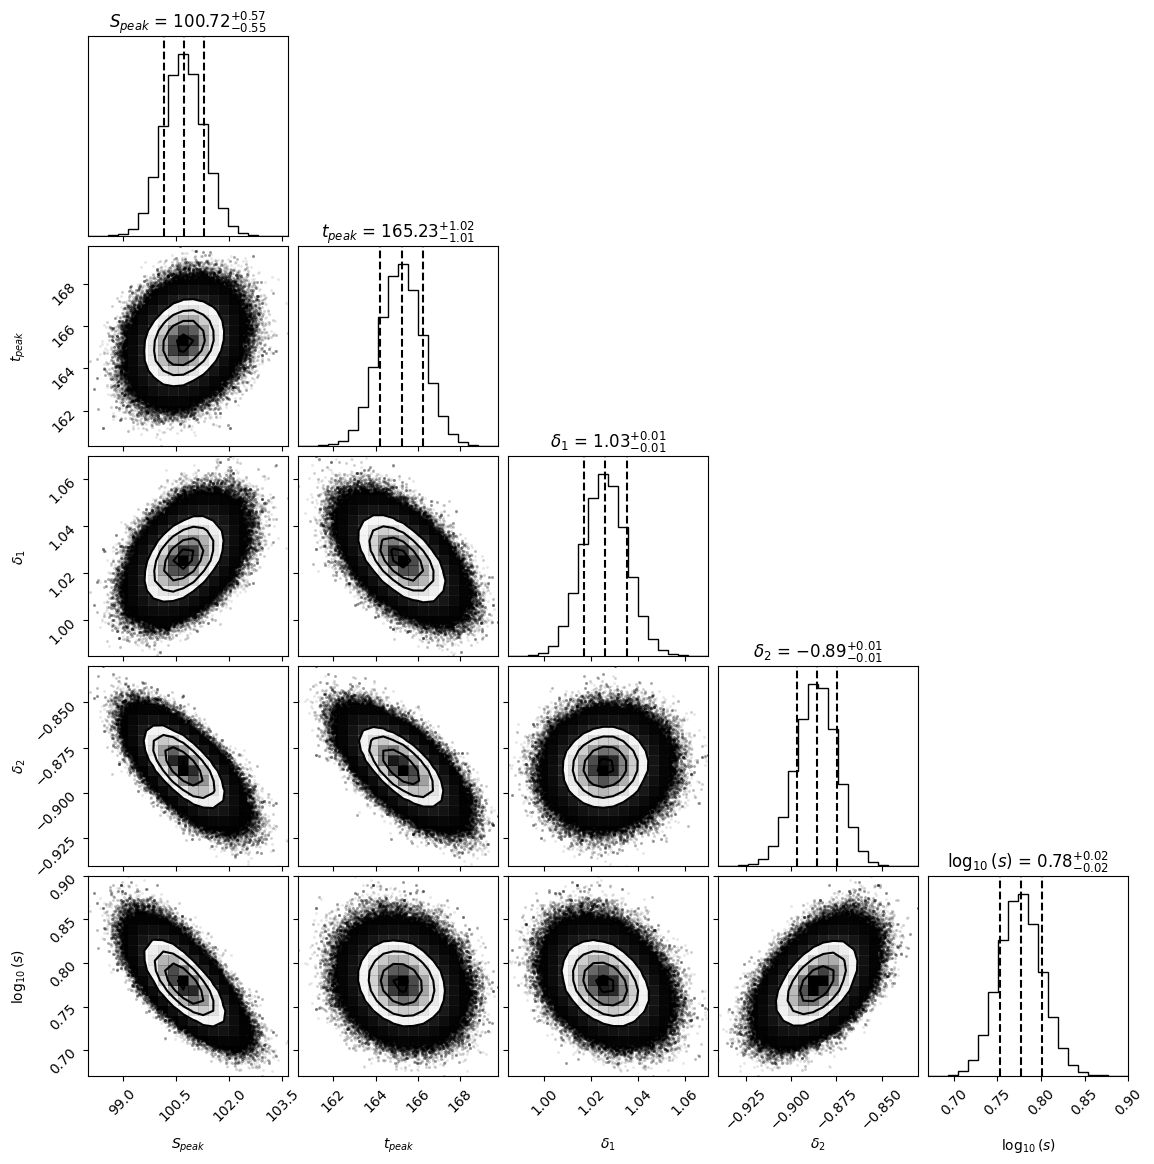

In [162]:
corner_plot(good_chain)

We'll now want to extract the value, median, and uncertainty (1 standard deviation) for each parameter. 

In [166]:
def extract_params(chain):   
    """
    Extract the value, median, and 1 standard deviation uncertainty from an MCMC chain.

    Parameters:
    - chain: The MCMC chain (shape: (nwalkers, niters, ndim))

    Returns:
    - best_params: A dictionary containing the value, median, and uncertainty for each parameter
    """

    ndim = chain.shape[2]
    params = ['Speak', 'tpeak', 'delta_1', 'delta_2', 'log_10s']

    # make sure the chain is the correct shape
    reshaped_chain = chain.reshape(-1, ndim)

    # calculate median and uncertainty 
    median = np.median(reshaped_chain, axis=0)
    uncertainty = np.std(reshaped_chain, axis=0)

    # store all the values in a dictionary 
    best_params = {}

    # extract the values and add them to the dictionary
    for i, (param) in enumerate(params):
        value = chain[0, 0, i]
        median_i = median[i]
        uncertainty_i = uncertainty[i]

        best_params[param] = {
            'Value':value,
            'Median':median_i,
            'Uncertainty':uncertainty_i
        }
    return best_params

In [172]:
best_params = extract_params(good_chain)
best_params

{'Speak': {'Value': 100.47334852470082,
  'Median': 100.71949719881052,
  'Uncertainty': 0.5627523255946419},
 'tpeak': {'Value': 164.95187902532447,
  'Median': 165.22787983564496,
  'Uncertainty': 1.024430400506558},
 'delta_1': {'Value': 1.0232127938498852,
  'Median': 1.0259339029764958,
  'Uncertainty': 0.009223925900274562},
 'delta_2': {'Value': -0.89101107922421,
  'Median': -0.8856924506621516,
  'Uncertainty': 0.011254977002111253},
 'log_10s': {'Value': 0.7898494156549849,
  'Median': 0.776438118973374,
  'Uncertainty': 0.024619468954199333}}

We'll also want to calculated the $\chi^2$ for the fit. Below is a function that will perform this calculation and return the value. Note that this $\chi^2$ is not meaningful, as my simulated data does not presently have errorbars. However, the functionality to calculate the $\chi^2$ value is there.

In [179]:
def chi2(best_params, params, model, data):
    '''
    Calculate the chi_2 for the model fit to the data.

    Parameters:
    - best_params: The value and uncertainty of the lightcurve parameters calculated from the fit
    - params: A list of the names of each of the parameters being fitted for
    - model: The model used to perform the fit to the data
    - data: The lightcurve data to which we fit our model

    Returns:
    - chi_2: The ch 
    '''
    t = data['time']
    flux = data['flux']
    rms = data['rms']

    args = []
    for param in params:
        args.append(best_params[param]['Value'])

    # define the best fit using the model and the parameter values calculated in the previous step
    best_fit = model(t, *args)

    # calculate the chi_2 value for the model
    chi_2 = np.sum((best_fit-flux)**2/(rms)**2)

    return chi_2

In [180]:
params = ['Speak', 'tpeak', 'delta_1', 'delta_2', 'log_10s']
chi2(best_params, params, smooth_broken_power_law, data)

34.99818724185596

The last thing we'll want to do with just this model, is plot our best fit along with the data. For this we should modify our make_plot() function to also plot models

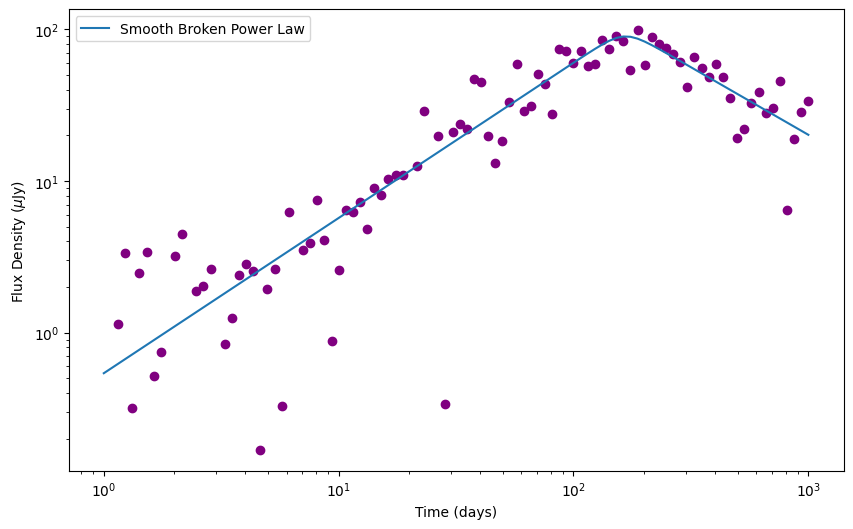

In [185]:
def plot_model(model, params, tval, ax):
    fit = model(tval, *params)
    ax.plot(tval, fit, label = 'Smooth Broken Power Law')
    ax.legend()
    return

params = ['Speak', 'tpeak', 'delta_1', 'delta_2', 'log_10s']
args = []
for param in params:
    args.append(best_params[param]['Value'])

make_plot(data, scaled=False, model=smooth_broken_power_law, params=args)